In [236]:
"""
This is THE model.

It combines improvements from the LLAMA3 series, with others from Gemma2.
It has:
- GQA
- GeGLU (thinking to maybe use SwiGLU or ReGLU)
- RoPE

I still would need to implement KV-caching to improve inference type.
"""
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.nn import functional as F
import math
import inspect

def repeat_kv(hidden_states: torch.Tensor, n_rep: int) -> torch.Tensor:
    """
    This is the equivalent of torch.repeat_interleave(x, dim=1, repeats=n_rep). The hidden states go from (batch,
    num_key_value_heads, seqlen, head_dim) to (batch, num_attention_heads, seqlen, head_dim)
    """
    batch, num_key_value_heads, slen, head_dim = hidden_states.shape
    if n_rep == 1:
        return hidden_states
    hidden_states = hidden_states[:, :, None, :, :].expand(batch, num_key_value_heads, n_rep, slen, head_dim)
    return hidden_states.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)


"""
class CausalSelfAttentionGQA(nn.Module):
    def __init__(self,config):
        super().__init__()
        assert config.n_embd % config.n_head == 0

        self.head_dim = config.n_embd // config.n_head
        self.n_kv_heads = config.n_kv_heads # Nombre de grups de query
        self.n_head = config.n_head

        shape = (config.n_head + 2 * config.n_kv_heads) * self.head_dim

        self.wq = nn.Linear(config.n_embd, config.n_head * self.head_dim, bias=False )
        self.wk = nn.Linear(config.n_embd, self.n_kv_heads * self.head_dim, bias=False)
        self.wv = nn.Linear(config.n_embd, self.n_kv_heads * self.head_dim, bias=False)
        self.wo = nn.Linear(config.n_head * self.head_dim, config.n_embd, bias=False)
        self.cache = None
        self.queries_per_kv = self.n_head // self.n_kv_heads

    def forward(self, x, freqs_cis, mask, return_attention=False):
        B, T, C = x.shape

        xq, xk, xv = self.wq(x), self.wk(x), self.wv(x)
        xq = xq.view(B, T, self.n_head, self.head_dim)
        xk = xk.view(B, T, self.n_kv_heads, self.head_dim)
        xv = xv.view(B, T, self.n_kv_heads, self.head_dim)

        xq = apply_rope(xq, freqs_cis)
        xk = apply_rope(xk, freqs_cis)

        xk = repeat_kv(xk, self.queries_per_kv)
        xv = repeat_kv(xv, self.queries_per_kv)
        print("aquí si")
        
        xq, xk, xv = (x.transpose(1, 2) for x in (xq, xk, xv))

        scores = torch.matmul(xq, xk.transpose(2, 3)) / math.sqrt(self.head_dim)
        if mask is not None:
            scores = scores + mask  # (bs, n_local_heads, seqlen, cache_len + seqlen)
        scores = F.softmax(scores.float(), dim=-1).type_as(xq)
        output = torch.matmul(scores, xv)

        output = output.transpose(1, 2).contiguous().view(B, T, -1)
        # output projection
        proj = self.wo(output)
        if return_attention:
            return proj, scores
        return proj
"""


def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)

def apply_rope(q, k, cos, sin, unsqueeze_dim=1):
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed


class CausalSelfAttentionGQA(nn.Module):
    def __init__(self,config):
        super().__init__()
        assert config.n_embd % config.n_head == 0

        self.config = config
        self.num_heads = config.n_head
        self.num_kv_heads = config.n_kv_heads
        self.head_dim = config.n_embd // self.num_heads
        self.num_kv_groups = self.num_heads // self.num_kv_heads
        

        self.q_proj = nn.Linear(config.n_embd, self.num_heads * self.head_dim, bias=False)
        self.k_proj = nn.Linear(config.n_embd, self.num_kv_heads * self.head_dim, bias=False)
        self.v_proj = nn.Linear(config.n_embd, self.num_kv_heads * self.head_dim, bias=False)
        self.o_proj = nn.Linear(self.num_heads * self.head_dim, config.n_embd, bias=False)


        #self.sliding_window_size = config.sliding_window_size
        self.max_seq_len = config.block_size

    def forward(self, x, cos_sin: tuple, return_attention = None):
        B, T, C = x.size()

        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        q = q.view(B, T, self.num_heads, self.head_dim).transpose(1,2)
        k = k.view(B, T, self.num_kv_heads, self.head_dim).transpose(1,2)
        v = v.view(B, T, self.num_kv_heads, self.head_dim).transpose(1,2)

        cos, sin = cos_sin
        q, k = apply_rope(q, k, cos, sin)

        k = repeat_kv(k, self.num_kv_groups)
        v = repeat_kv(v, self.num_kv_groups)

        scores = torch.matmul(q, k.transpose(2,3)) / math.sqrt(self.head_dim)

        mask = True
        if mask is not None:  # the mask is not correct, it needs to be [B, C, T, T]
            mask = torch.full((T, T), float("-inf"), device=x.device)
            mask = torch.triu(mask, diagonal=1)
            mask = mask.unsqueeze(0).unsqueeze(1)
            scores = scores + mask

        scores = nn.functional.softmax(scores, dim=-1, dtype=torch.float32).to(q.dtype)
        output = torch.matmul(scores, v)

        if output.size() != (B, self.num_heads, T, self.head_dim):
            raise ValueError(f"ALGO HA ANAT MALAMENT, output té dimensions {output.size()}")
        
        output = output.transpose(1,2).contiguous()
        output = output.reshape(B, T, -1)

        output = self.o_proj(output)

        if return_attention:
            return output, scores
        return output, None
        

class RMSNorm(nn.Module):
    def __init__(self, d, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(d)) # weight

    def forward(self, x):
        input_dtype = x.dtype
        x = x.to(torch.float32)
        variance = x.pow(2).mean(-1, keepdim=True)
        hidden_states = x * torch.rsqrt(variance + self.eps)
        return self.weight * hidden_states.to(input_dtype)


def compute_rope_default(config, device):
    base = config.rope_theta
    dim = config.n_embd // config.n_head

    inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2, dtype=torch.int64).float().to(device)/dim))
    return inv_freq, 1.0



class LlamaRotaryEmbedding(nn.Module):
    def __init__(self, config, device = None):
        super().__init__()
        self.max_position_embeddings = config.max_position_embeddings
        self.factor = config.scaling_factor
        self.base = config.rope_theta
        self.dim = config.n_embd // config.n_head
        self.config = config
        self.rope_init_fn = compute_rope_default

        inv_freq, self.attention_scaling = self.rope_init_fn(self.config, device)
        self.register_buffer("inv_freq", inv_freq, persistent=False)
        self.original_inv_freq = self.inv_freq
    
    @torch.no_grad()
    def forward(self, x, position_ids):
        inv_freq_expanded = self.inv_freq[None, :, None].float().expand(position_ids.shape[0], -1, 1)
        position_ids_expanded = position_ids[:, None, :].float()
        device_type = x.device.type
        device_type = device_type if isinstance(device_type, str) and device_type != "mps" else "cpu"
        with torch.autocast(device_type=device_type, enabled=False):
            freqs = (inv_freq_expanded.float() @ position_ids_expanded.float()).transpose(1, 2)
            emb = torch.cat((freqs, freqs), dim=-1)
            cos = emb.cos()
            sin = emb.sin()

        # Advanced RoPE types (e.g. yarn) apply a post-processing scaling factor, equivalent to scaling attention
        cos = cos * self.attention_scaling
        sin = sin * self.attention_scaling

        return cos.to(dtype=x.dtype), sin.to(dtype=x.dtype)

        

class MLP(nn.Module):
    """
    class GeGLU(nn.Module):
    def forward(self, x):
        x, gate = x.chunk(2, dim=-1)
        # Silu és el mateix que swift function
        return F.gelu(gate) * x
    
    """
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.gate_proj   = nn.Linear(config.n_embd, config.intermediate_size, bias=False) # gate_proj
        self.down_proj = nn.Linear(config.intermediate_size, config.n_embd, bias=False) # down proj
        self.up_proj = nn.Linear(config.n_embd, config.intermediate_size, bias=False) # up proj
    
    def forward(self, x):
        return self.down_proj(F.gelu(self.gate_proj(x), approximate="tanh")* self.up_proj(x)) 


class Block(nn.Module):

    def __init__(self,config):
        super().__init__()
        self.input_layernorm = RMSNorm(config.n_embd, config.norm_eps) # input_layernorm
        self.self_attn = CausalSelfAttentionGQA(config)
        self.post_attention_layernorm = RMSNorm(config.n_embd, config.norm_eps) # post_attention_layernorm
        self.mlp = MLP(config)
    
    def forward(self, x, cos_sin):
        residual = x
        x = self.input_layernorm(x)
        x, attn_weights = self.self_attn(x, cos_sin)

        x = residual + x

        residual = x
        x = self.post_attention_layernorm(x)
        x = self.mlp(x)
        x = residual + x

        return x

class Aloja(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config


        self.padding_idx = config.pad_token_id
        self.embed_tokens =nn.Embedding(config.vocab_size, config.n_embd, self.padding_idx)

        self.layers = nn.ModuleList([Block(config) for i in range(config.n_layer)])

        self.norm =  RMSNorm(config.n_embd, config.norm_eps)
        self.rotary_emb = LlamaRotaryEmbedding(config=config)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        self.embed_tokens.weight = self.lm_head.weight # Linkeddddd

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            torch.nn.init.normal_(module.weight, mean = 0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()

    def forward(self, idx, targets=None):
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is smaller"

        x = self.embed_tokens(idx)


        position_ids = torch.arange(T, device = x.device).unsqueeze(0)

        


        cos_sin = self.rotary_emb(x, position_ids)

        for block in self.layers:
            x = block(x, cos_sin)
        
        x = self.norm(x)

        logits = self.lm_head(x).float()

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        
        return logits, loss
    
    def configure_optimizers(self, learning_rate, weight_decay=0.1, betas=(0.9, 0.95), device_type='cuda'):
        param_dict = {pn: p for pn, p in self.named_parameters()}
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == "cuda"
        print(f"using fused AdamW: {use_fused}")
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, eps=1e-8, fused=use_fused)
        return optimizer


@dataclass
class AlojaConfig:
    block_size: int = 128
    vocab_size: int = 500
    n_layer: int = 2
    n_head: int = 2
    n_embd: int = 192 # hidden_size
    intermediate_size = 128 # 3072
    n_kv_heads: int = 1 # nombre de grups de query
    norm_eps: int = 1e-05
    rope_theta: float = 10000.0
    use_scaled_rope: bool = False
    scaling_factor: int = 1
    max_batch_size: int = 16
    max_seq_len:int = 128
    max_position_embeddings:int = 128
    pad_token_id:int = 3


In [237]:
model_config = AlojaConfig()

model = Aloja(model_config)

In [356]:
"""
Full definition of a GPT Language Model, all of it in this single file.
References:
1) the official GPT-2 TensorFlow implementation released by OpenAI:
https://github.com/openai/gpt-2/blob/master/src/model.py
2) huggingface/transformers PyTorch implementation:
https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py
"""

import math
import inspect
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F

class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        # flash attention make GPU go brrrrr but support is only in PyTorch >= 2.0
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        self.flash = False
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            # causal mask to ensure that attention is only applied to the left in the input sequence
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                        .view(1, 1, config.block_size, config.block_size))
        

    def forward(self, x, return_attention = False):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        if self.flash:
            # efficient attention using Flash Attention CUDA kernels
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        else:
            # manual implementation of attention
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        if return_attention:
            return y, att
        return y

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int = 128
    vocab_size: int = 500 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 2
    n_head: int = 2
    n_embd: int = 192
    dropout: float = 0.0
    bias: bool = False # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster


class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        # with weight tying when using torch.compile() some warnings get generated:
        # "UserWarning: functional_call was passed multiple values for tied weights.
        # This behavior is deprecated and will be an error in future versions"
        # not 100% sure what this is, so far seems to be harmless. TODO investigate
        self.transformer.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

    def crop_block_size(self, block_size):
        # model surgery to decrease the block size if necessary
        # e.g. we may load the GPT2 pretrained model checkpoint (block size 1024)
        # but want to use a smaller block size for some smaller, simpler model
        assert block_size <= self.config.block_size
        self.config.block_size = block_size
        self.transformer.wpe.weight = nn.Parameter(self.transformer.wpe.weight[:block_size])
        for block in self.transformer.h:
            if hasattr(block.attn, 'bias'):
                block.attn.bias = block.attn.bias[:,:,:block_size,:block_size]

    @classmethod
    def from_pretrained(cls, model_type, override_args=None):
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        override_args = override_args or {} # default to empty dict
        # only dropout can be overridden see more notes below
        assert all(k == 'dropout' for k in override_args)
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        print("forcing vocab_size=50257, block_size=1024, bias=True")
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        config_args['bias'] = True # always True for GPT model checkpoints
        # we can override the dropout rate, if desired
        if 'dropout' in override_args:
            print(f"overriding dropout rate to {override_args['dropout']}")
            config_args['dropout'] = override_args['dropout']
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        # start with all of the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f"using fused AdamW: {use_fused}")

        return optimizer

    def estimate_mfu(self, fwdbwd_per_iter, dt):
        """ estimate model flops utilization (MFU) in units of A100 bfloat16 peak FLOPS """
        # first estimate the number of flops we do per iteration.
        # see PaLM paper Appendix B as ref: https://arxiv.org/abs/2204.02311
        N = self.get_num_params()
        cfg = self.config
        L, H, Q, T = cfg.n_layer, cfg.n_head, cfg.n_embd//cfg.n_head, cfg.block_size
        flops_per_token = 6*N + 12*L*H*Q*T
        flops_per_fwdbwd = flops_per_token * T
        flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
        # express our flops throughput as ratio of A100 bfloat16 peak flops
        flops_achieved = flops_per_iter * (1.0/dt) # per second
        flops_promised = 312e12 # A100 GPU bfloat16 peak flops is 312 TFLOPS
        mfu = flops_achieved / flops_promised
        return mfu

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

In [357]:
model_config2 = GPTConfig()
model2 = GPT(model_config2)

number of parameters: 0.98M


In [358]:

import numpy as np
import torch
import math
from torch.nn import functional as F

def load_tokens(filename):
    with open(filename, "rb") as f:
      file_content = f.read()

    npt = np.frombuffer(file_content, dtype=np.uint16)
    npt = npt.astype(np.int32)
    ptt = torch.tensor(npt, dtype=torch.long)

    return ptt


def get_most_likely_row(tokens, mask, logits):
    shift_logits = (logits[..., :-1, :]).contiguous()
    shift_tokens = (tokens[..., 1:]).contiguous()
    flat_shift_logits = shift_logits.view(-1, shift_logits.size(-1))
    flat_shift_tokens = shift_tokens.view(-1)
    shift_losses = F.cross_entropy(flat_shift_logits, flat_shift_tokens, reduction='none')
    shift_losses = shift_losses.view(tokens.size(0), -1)
    # now get the average loss just for the completion region (where mask == 1), in each row
    shift_mask = (mask[..., 1:]).contiguous().to(logits.device) # we must shift mask, so we start at the last prompt token
    masked_shift_losses = shift_losses * shift_mask
    # sum and divide by the number of 1s in the mask
    sum_loss = masked_shift_losses.sum(dim=1)
    avg_loss = sum_loss / shift_mask.sum(dim=1)
    # now we have a loss for each of the 4 completions
    # the one with the lowest loss should be the most likely
    pred_norm = avg_loss.argmin().item()
    return pred_norm


class DataLoaderLite:
    def __init__(self, B, T,split):
        self.B = B
        self.T = T
        assert split in {'train', 'val'}

        # get the shard filenames
        data_root = "./data/patufet-mini"
        shards = os.listdir(data_root)
        shards = [s for s in shards if split in s]
        shards = sorted(shards)
        shards = [os.path.join(data_root, s) for s in shards]
        print("Shards:", shards)
        self.shards = shards
        assert len(shards) > 0, f"no shards found for split {split}"
        print(f"found {len(shards)} shards for split {split}")
        self.reset()

    def reset(self):
        # state, init at shard zero
        self.current_shard = 0
        self.tokens = load_tokens(self.shards[self.current_shard])
        self.current_position = 0

    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position : self.current_position+B*T+1]
        x = (buf[:-1]).view(B, T) # inputs
        y = (buf[1:]).view(B, T) # targets
        # advance the position in the tensor
        self.current_position += B * T
        # if loading the next batch would be out of bounds, advance to next shard
        if self.current_position + (B * T + 1) > len(self.tokens):
            self.current_shard = (self.current_shard + 1) % len(self.shards)
            self.tokens = load_tokens(self.shards[self.current_shard])
            self.current_position = 0
        return x, y



# ------------------------------------------------------------------------------
# torchrun --standalone --nproc_per_node=8 train_gpt2.py


import os
import time

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"Using device {device}")

device_type = "cuda" if device.startswith("cuda") else "cpu"

torch.manual_seed(1337)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

from tokenizers import Tokenizer
enc = Tokenizer.from_file("./tokenizer/mini.tokenizer.json")


total_batch_size = 1024
B = 2
T = 128


grad_accum_steps = total_batch_size // (B*T)
print(f"Total desired batach size: {total_batch_size}")
print(f"Calculated gradient accumulation steps: {grad_accum_steps}")

train_loader = DataLoaderLite(B=B, T =T, split="train")
val_loader = DataLoaderLite(B=B, T =T, split="val")

torch.set_float32_matmul_precision("high")

model_config = AlojaConfig()

model = Aloja(model_config)



model.to(device)
use_compile = True
model = torch.compile(model)

max_lr = 3e-4
min_lr = max_lr * 0.1
warmup_steps = 200
max_steps = 19000

def get_lr(it):
    if it < warmup_steps:
        return max_lr * (it+1) / warmup_steps
    if it > max_steps:
        return min_lr
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (max_lr - min_lr)

#optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, betas = (0.9, 0.95), eps=1e-8)

model.train()
optimizer = model.configure_optimizers(weight_decay=0.0, learning_rate=3e-4, device_type=device_type)

log_dir = "log"
os.makedirs(log_dir, exist_ok=True)
log_file = os.path.join(log_dir, f"log.txt")
with open(log_file, "w") as f:
    pass

for step in range(max_steps):
    t0 = time.time()
    last_step = (step == max_steps -1)
    model.train()
    optimizer.zero_grad()
    loss_accum = 0.0
    for micro_step in range(grad_accum_steps):
        x, y = train_loader.next_batch()
        x, y = x.to(device), y.to(device)

        if device == "cuda":
            with torch.autocast(device_type=device, dtype=torch.bfloat16):
                logits, loss = model(x, y)
        else:
            logits, loss = model(x, y)
        loss = loss / grad_accum_steps
        loss_accum += loss.detach()
        loss.backward()
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    lr = get_lr(step)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    optimizer.step()
    if device_type == "cuda":
        torch.cuda.synchronize()
    t1 = time.time()
    dt = (t1 - t0)*1000
    tokens_per_sec = (train_loader.B * train_loader.T * grad_accum_steps) / (t1-t0)
    print(f"step {step:4d}, loss: {loss_accum.item():.6f}, norm: {norm:.4f}, dt: {dt:.2f}ms, tok/sec: {tokens_per_sec:.2f}")
    with open(log_file, "a") as f:
        f.write(f"{step} train {loss_accum.item():.6f}\n")
    if step > 0 and (step % 1000 == 0 or last_step):
        checkpoint_path = os.path.join(log_dir, f"model_{step:05d}.pt")
        checkpoint = {
            'model': model.state_dict(),
            'config': model.config,
            'step': step,
            'optimizer': optimizer.state_dict()
        }
        torch.save(checkpoint, checkpoint_path)


Using device cpu
Total desired batach size: 1024
Calculated gradient accumulation steps: 4
Shards: ['./data/patufet-mini\\patufet_train_000001', './data/patufet-mini\\patufet_train_000002', './data/patufet-mini\\patufet_train_000003']
found 3 shards for split train
Shards: ['./data/patufet-mini\\patufet_val_000000']
found 1 shards for split val
number of parameters: 0.98M
num decayed parameter tensors: 10, with 1,005,312 parameters
num non-decayed parameter tensors: 5, with 960 parameters
using fused AdamW: False
step    0, loss: 6.258945, norm: 1.9119, dt: 226.04ms, tok/sec: 4530.13
step    1, loss: 6.116513, norm: 1.7941, dt: 252.70ms, tok/sec: 4052.31
step    2, loss: 5.844625, norm: 1.3013, dt: 215.49ms, tok/sec: 4752.04
step    3, loss: 5.700125, norm: 1.3333, dt: 211.39ms, tok/sec: 4844.22
step    4, loss: 5.471749, norm: 1.6726, dt: 213.07ms, tok/sec: 4805.94
step    5, loss: 5.590451, norm: 9.1753, dt: 182.20ms, tok/sec: 5620.20
step    6, loss: 5.027242, norm: 1.5857, dt: 200.

KeyboardInterrupt: 

In [300]:
train_loader2 = DataLoaderLite(B=B, T =T, split="train")

Shards: ['./data/patufet-mini\\patufet_train_000001', './data/patufet-mini\\patufet_train_000002', './data/patufet-mini\\patufet_train_000003']
found 3 shards for split train


In [548]:
a = (train_loader2.next_batch())
print(a[0][0])
print(train_loader2.current_shard)

tensor([287, 288, 297, 405,  74, 288, 280, 399, 294, 376, 323, 300, 440, 443,
        394, 273, 306, 328, 481,  92, 314,  88, 299, 280, 401, 268,  76, 276,
         74, 294, 354, 307,  92, 275, 284,  82, 318, 291, 294, 273,  94,  75,
        365, 277, 268, 326,  80, 289,  92,  18,  21, 291, 339,  82, 281, 348,
        374, 460, 470, 288, 318,  75, 320, 270, 287, 275, 343,  74, 339,  82,
        286, 362,  94, 313, 268, 270, 492, 273, 413, 456, 321, 291, 336,  94,
        273, 297, 313,  86, 282,  82,  23, 392,  82, 429,  92, 301, 288, 330,
         83, 280,  92, 401,  92, 432, 284, 315,  93, 416,  80, 271,  92,  18,
        283, 330,  94, 268, 287, 299, 285,  93, 289,  74, 317, 339,  82, 326,
        300, 306])
0


In [306]:
tokenizer.decode(a[0][0].tolist())

'ón res més que un maquillatge per poder seguir amagant el que realment la societat necessita saber en un estat democràtic del S.XXI.CYBERSQUIRRELS! - Infoself Group\nCYBERSQUIRRELS!\nCom alguns ja sabreu fa pocs dies (27 de novem'

In [359]:
import torch
import torch.nn.functional as F

# Function to generate text continuation
def generate_text(model, tokenizer, input_text, max_length=50, temperature=0.1, top_k=1):
    model.eval()
    input_ids = torch.Tensor(np.array(tokenizer.encode(input_text).ids, dtype=np.int32)).type(torch.int32).to(device)

    input_ids = input_ids.unsqueeze(0)
    generated = input_ids
    for _ in range(max_length):
        with torch.no_grad():
            logits, _ = model(generated)
        
        # Select the logits of the last token
        logits = logits[:, -1, :] / temperature

        # Apply top-k sampling
        if top_k > 0:
            top_k_values, top_k_indices = torch.topk(logits, top_k)
            logits = torch.zeros_like(logits).scatter_(1, top_k_indices, top_k_values)
        
        # Convert logits to probabilities and sample
        probabilities = F.softmax(logits, dim=-1)
        next_token = torch.multinomial(probabilities, num_samples=1)

        # Append sampled token to generated sequence
        generated = torch.cat((generated, next_token), dim=1)


    # Decode the generated tokens to text
    generated_text = tokenizer.decode(generated[0].tolist())
    return generated_text

# Example usage
input_text = "</s> "
generated_text = generate_text(model, tokenizer, input_text, max_length=50, temperature=1.0, top_k=50)
print(generated_text)


 us enlLa l'el dels? hojor con pa, no hoqu dat nos vort ens joquen el casta delhYBERS! Di l


In [363]:
input_ids = torch.Tensor(np.array(tokenizer.encode(input_text).ids, dtype=np.int32)).type(torch.int32).to(device)
input_ids = input_ids.unsqueeze(0)
generated = model.generate(input_ids, 50)
generated_text = tokenizer.decode(generated[0].tolist())
print(generated_text)

 us enl "cidors que sdeo que no és meu,nnil d man exaconiuim un pressarcç o pubar a una d'eia ens


In [245]:
tokenizer.decode([270, 490, 268, 387, 291, 230, 375,  85, 433, 283, 268,  76, 271,  21,
         314,  82, 314,  78, 269,  79, 440, 330, 347,  80, 284, 381, 470,  21,
         230, 375, 335, 314,  78, 300, 484, 294, 315, 299,  78, 333, 307, 326,
          80, 289,  74, 474,  78,  89, 274])

' de presentar el tall tot sencer, hi he afegit ingredients, tal com he vist que es feia en alguna recepta'

In [364]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_attention(model, tokenizer, sentence, layer_num, head_num):
    # Tokenize the input sentence
    input_ids = torch.Tensor(np.array(tokenizer.encode(sentence).ids, dtype=np.int32)).type(torch.int32)

    
    
    # Move input to the same device as the model
    input_ids = input_ids.to(next(model.parameters()).device)
    T = len(input_ids)
    input_ids = input_ids.unsqueeze(0)

    
    print(T)
    x = model.embed_tokens(input_ids)


    position_ids = torch.arange(T, device = x.device).unsqueeze(0)

    


    cos_sin = model.rotary_emb(x, position_ids)
    
    _, attention_weights = model.layers[layer_num].self_attn(x, cos_sin, return_attention=True)

    # Select the attention weights for the specified head
    attention_weights = attention_weights[0, head_num].detach().cpu().numpy()

    # Plot the attention weights
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_weights, cmap="viridis", xticklabels=[str(enc.decode([ll])) for ll in input_ids.tolist()[0]], yticklabels=[str(enc.decode([ll])) for ll in input_ids.tolist()[0]])
    plt.title(f"Attention Weights - Layer {layer_num + 1}, Head {head_num + 1}")
    plt.xlabel("Key Position")
    plt.ylabel("Query Position")
    plt.show()


In [126]:
input_ids = torch.Tensor(np.array(tokenizer.encode("La nena juga amb les seves joguines").ids, dtype=np.int32)).type(torch.int32)

    
    
# Move input to the same device as the model
input_ids = input_ids.to(next(model.parameters()).device)
T = len(input_ids)
input_ids = input_ids.unsqueeze(0)
enc.decode(input_ids.tolist()[0])

'La nena juga amb les seves joguines'

In [375]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_attention(model, tokenizer, sentence, layer_num, head_num):
    # Tokenize the input sentence
    input_ids = torch.Tensor(np.array(tokenizer.encode(sentence).ids, dtype=np.int32)).type(torch.int32)

    print(input_ids.tolist())

    pos = torch.arange(0, len(input_ids), dtype=torch.long)
    tok_emb = model.transformer.wte(input_ids) # token embeddings of shape (b, t, n_embd)
    pos_emb = model.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
    x = model.transformer.drop(tok_emb + pos_emb)

    x = x.unsqueeze(0)
    
    layer = model.transformer.h[layer_num]
    _, attention_weights = layer.attn(x, return_attention=True)

    # Select the attention weights for the specified head
    attention_weights = attention_weights[0, head_num].detach().cpu().numpy()

    # Plot the attention weights
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_weights, cmap="viridis", xticklabels=[str(enc.decode([ll])) for ll in input_ids.tolist()], yticklabels=[str(enc.decode([ll])) for ll in input_ids.tolist()])
    plt.title(f"Attention Weights - Layer {layer_num + 1}, Head {head_num + 1}")
    plt.xlabel("Key Position")
    plt.ylabel("Query Position")
    plt.show()


In [371]:
input_ids.tolist()

[[1, 230]]

[53, 74, 311, 268, 74, 397, 94, 80, 74, 344, 331, 336, 486, 397, 88, 334, 304, 267]


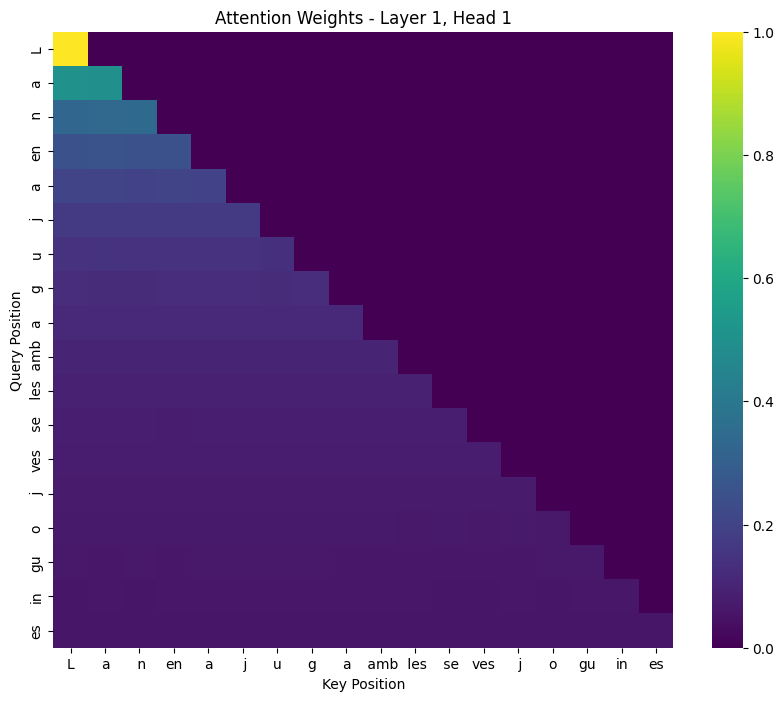

In [376]:
# Example usage
from tokenizers import Tokenizer
tokenizer = Tokenizer.from_file("./tokenizer/mini.tokenizer.json")


sentence = "La nena juga amb les seves joguines"
layer_num = 0  # Specify the layer number (0-indexed)
head_num = 0  # Specify the head number (0-indexed)

visualize_attention(model, tokenizer, sentence, layer_num, head_num)


In [66]:
checkpoint = torch.load("./src/model_00576.pt", map_location="cpu")

C:\Users\Usuario\AppData\Local\Temp\ipykernel_29452\3942902272.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("./src/model_00576.pt", map_locati

In [75]:
checkpoint['config'].intermediate_size = 128

In [99]:
class AlojaConfig:
    block_size: int = 2048
    vocab_size: int = 65536
    n_layer: int = 30
    n_head: int = 8
    n_embd: int = 768
    intermediate_size = 2048 # 3072
    n_kv_heads: int = 4 # nombre de grups de query
    norm_eps: int = 1e-05
    rope_theta: float = 1000.0
    use_scaled_rope: bool = False
    max_batch_size: int = 32
    max_seq_len:int = 2048

In [100]:
config = AlojaConfig()

In [101]:
model_bad = Aloja(config)
model_bad.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_attention(model, tokenizer, sentence, layer_num, head_num):
    # Tokenize the input sentence
    input_ids = torch.Tensor(np.array(tokenizer.encode(sentence).ids, dtype=np.int32)).type(torch.int32)

    
    
    # Move input to the same device as the model
    input_ids = input_ids.to(next(model.parameters()).device)
    T = len(input_ids)
    input_ids = input_ids.unsqueeze(0)

    
    print(T)
    mask = torch.full((T, T), float("-inf"), device=input_ids.device)
    mask = torch.triu(mask, diagonal=1)
    mask = mask.type_as(x)

    # Forward pass through the model with return_attention=True
    print(input_ids[0])
    passed = model.transformer.wte(input_ids)
    print(passed.shape)

    freqs = model.freqs[:T]
    
    _, attention_weights = model.transformer.h[layer_num].attn(passed, freqs, mask, return_attention=True)

    # Select the attention weights for the specified head
    attention_weights = attention_weights[0, head_num].detach().cpu().numpy()

    # Plot the attention weights
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_weights, cmap="viridis", xticklabels=sentence.split(), yticklabels=sentence.split())
    plt.title(f"Attention Weights - Layer {layer_num + 1}, Head {head_num + 1}")
    plt.xlabel("Key Position")
    plt.ylabel("Query Position")
    plt.show()


8
tensor([   57, 33682, 44884,  5787,  1170, 33785,  1905,    23],
       dtype=torch.int32)
torch.Size([1, 8, 768])


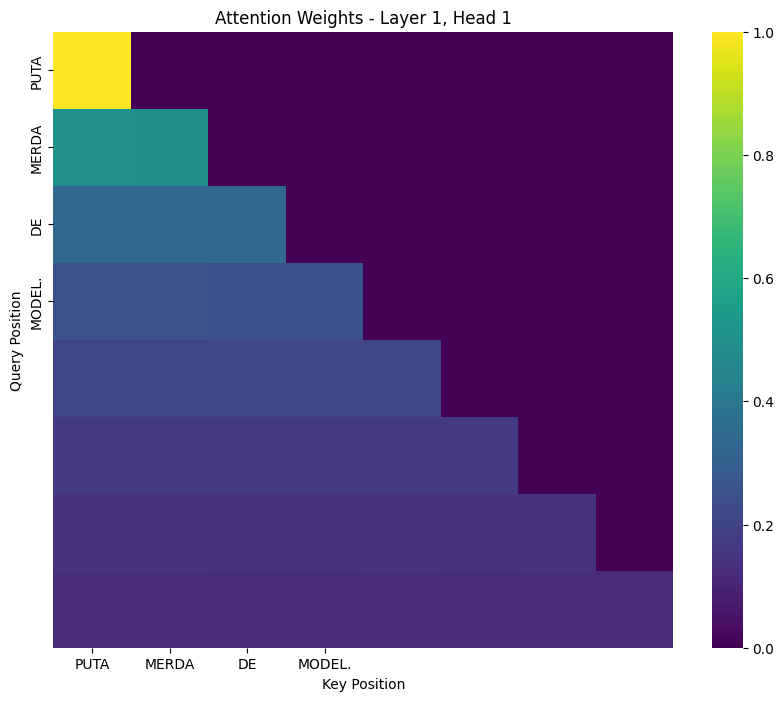

In [102]:
# Example usage
model = Aloja(AlojaConfig())
from tokenizers import Tokenizer
tokenizer = Tokenizer.from_file("./tokenizer/byte-level-bpe.tokenizer.json")


sentence = "PUTA MERDA DE MODEL."
layer_num = 0  # Specify the layer number (0-indexed)
head_num = 0   # Specify the head number (0-indexed)

visualize_attention(model_bad, tokenizer, sentence, layer_num, head_num)


In [57]:
a = train_loader2.next_batch()

In [63]:
print(enc.decode(a[0][1].tolist()))

 de la societat romana, nens i nenes com ells, amb els seus pares, germans, avis.
A través de la presentació dels productes podran tocar, olorar, veure i fins i tot tastar una gran varietat de productes natuals i receptes que els portaran a un món força conegut per ells, entenent així la importància de la dieta mediterrània i el seu inici que es remunta més de 2000 anys enrere. No només parlarem d'aquestes aliments crus sinó també els difrents tipus de cocció, els estris necessaris i aliments encara desconeguts per la societat romana.
Aquesta és una activitat pensada especialment per l'Educació Primària, tot i que es pot adaptar a l'Educació Secundària i al públic adult, passant a un nivell de comprensió més complexe i amb altres tipus de productes.
Per a ampliar la informació no dubteu en posar-vos en contacte amb nosaltres a través de la nostra bústia de correu electrònic: associació@cella-vinaria.comSOLE & HERNANDEZ – Cóm desenvolupar campanyes de màrqueting de continguts per a PIME

In [61]:
print(enc.decode(a[1][1].tolist()))

 la societat romana, nens i nenes com ells, amb els seus pares, germans, avis.
A través de la presentació dels productes podran tocar, olorar, veure i fins i tot tastar una gran varietat de productes natuals i receptes que els portaran a un món força conegut per ells, entenent així la importància de la dieta mediterrània i el seu inici que es remunta més de 2000 anys enrere. No només parlarem d'aquestes aliments crus sinó també els difrents tipus de cocció, els estris necessaris i aliments encara desconeguts per la societat romana.
Aquesta és una activitat pensada especialment per l'Educació Primària, tot i que es pot adaptar a l'Educació Secundària i al públic adult, passant a un nivell de comprensió més complexe i amb altres tipus de productes.
Per a ampliar la informació no dubteu en posar-vos en contacte amb nosaltres a través de la nostra bústia de correu electrònic: associació@cella-vinaria.comSOLE & HERNANDEZ – Cóm desenvolupar campanyes de màrqueting de continguts per a PIMES?


In [68]:
model.to(device)
model.eval()
num_return_sequences = 4
max_length = 32
tokens = list(enc.encode("Hola, sóc un model de llenguatge").ids)
tokens = torch.tensor(tokens, dtype=torch.long)
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
xgen = tokens.to(device)
sample_rng = torch.Generator(device=device)
sample_rng.manual_seed(42)
while xgen.size(1) < max_length:
    with torch.no_grad():
        with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
            logits, loss = model(xgen) # (B, T, vocab_size)
        logits = logits[:, -1, :] # (B, vocab_size)
        probs = F.softmax(logits, dim=-1)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        ix = torch.multinomial(topk_probs, 1, generator=sample_rng) # (B, 1)
        xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
        xgen = torch.cat((xgen, xcol), dim=1)
# print the generated text
for i in range(num_return_sequences):
    tokens = xgen[i, :max_length].tolist()
    decoded = enc.decode(tokens)
    print(f"sample {i}: {decoded}")

W0828 13:55:13.022000 139722774890304 torch/fx/experimental/symbolic_shapes.py:4449] [0/8] xindex is not in var_ranges, defaulting to unknown range.
W0828 13:56:12.995000 139722774890304 torch/fx/experimental/symbolic_shapes.py:4449] [0/9] xindex is not in var_ranges, defaulting to unknown range.


sample 0: Hola, sóc un model de llenguatge de por qualsevol de fer una sol posar poc de cada més millor què ells tots més més ens més tots més millor que més
sample 1: Hola, sóc un model de llenguatge), in una simple sense una bona així una massa possible molts més cada mateix una més més més més més més més baixa té
sample 2: Hola, sóc un model de llenguatge, un què menys aigua cert aquests una si molta més si aquests massa més si els més més més més més a aquests o
sample 3: Hola, sóc un model de llenguatge per bo una és com més millor totalment què alguna més més tens que més si aquesta bé més millor això si menys persona molt
